# Transferability of models trained with weighted-SOAP to larger system sizes: Bulk-Cu

This notebook will demonstrate the use of a NN model trained with weighted-SOAP descriptors can be used for larger periodic cells. 

Importing required packages. For this demonstration, let's build NNs with pyTorch and train them on GPU (M1 Mac).

In [1]:
import torch
import math
import numpy as np
import dscribe
from ase.build import molecule
from dscribe.descriptors import SOAP
from ase.io import read, write
from ase import Atom, Atoms
import time
import os
import sys
import pickle
from ase.io.cube import read_cube, write_cube
from sklearn.metrics import explained_variance_score, mean_squared_error
import py3Dmol
sys.path.append('deepcdp/')
from deepcdp import deepcdp
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import pandas as pd
import sklearn.metrics as skmetrics
from sklearn.neural_network import MLPRegressor
import gc
import zipfile
import pandas as pd
from tqdm import tqdm
from ase.build import bulk
from ase.visualize.plot import plot_atoms

import datetime
import matplotlib.pyplot as plt
import random
import torch.utils.data as utils_data
from torch.autograd import Variable
from torch.nn.modules.dropout import Dropout

import warnings
warnings.filterwarnings('ignore')

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Device: ", device)

# This ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# This ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

Device:  mps
True
True


We will train our models with the small Cu FCC cell containing two atoms. 

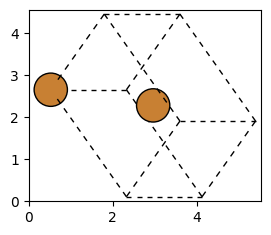

In [2]:
# We will use ase's bulk function. Set up an orthorhombic cell. 
copper_ortho = bulk('Cu', 'fcc', a=3.6, orthorhombic=True)
# view(copper_ortho, viewer='x3d') # uncomment this if you want to have an interactive view
fig, ax = plt.subplots(figsize=(3,3))
plot_atoms(copper_ortho, ax, radii=0.3, rotation=('45x,45y,0z'))
plt.show()

Generating the SOAP function with DScribe. Our SOAP is coded to be periodic along all three dimensions. For computational convenience, let's use a shorter cut off radius and number number of RBFs and degrees of spherical harmonics. 

In [3]:
rcut = 2.54 # Local cut off
nmax = 4 # max number of radial basis functions
lmax = 4 # maximum degree of spherical harmonics

copper_ortho = bulk('Cu', 'fcc', a=3.6, orthorhombic=True)
print('Periodic = ',copper_ortho.get_pbc()) # checking for periodicity in ase

copper_soap_W = SOAP( # W = with weighting
    species=[29],
    rcut=rcut,
    nmax=nmax,
    lmax=nmax,
    sigma=1,
    periodic=True,
    sparse=False,
    weighting={"function":"poly","r0":2,"c":2,"m":2}
)

Periodic =  [ True  True  True]


Loading data.

In [4]:
# Use the 6 DFT data points.
subsample=10

# Path of the file and filename prefix
datapath = 'data/bulk-Cu/'
datafilename = 'Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_' 
all_files = os.listdir(f'{datapath}')
data_files =[x for x in all_files 
               if x.split('.')[-1] == 'cube']
idxList=[int(x.split('.cube')[0].split('_')[-1]) 
         for x in data_files if x.split('.')[-1] == 'cube']



cubefile = lambda x:f'{datapath}{x}' # creating a lambda function
print(idxList)
# generating an object of type deepcdp (imported)
CDP_W=deepcdp(copper_soap_W)

# generates a box of points. Be mindful of the gamma value used.
CDP_W.create_box(sample_cubeFile=datapath+data_files[0], gamma=90)

totalfiles=int(os.popen(f'ls {datapath} | wc -l').read().split('\n')[0])

# useing ase's read_cube to read a sample cube file
dicttest=read_cube(open(datapath+data_files[0]))
sampleSubs=dicttest['atoms']
sampleSubs.set_pbc((True, True, True))

# randomly picking snapshots for training
data_files_sub = random.sample(data_files, k=subsample)

# generating final dataset
CDP_W.generate_cube_data(data_files_sub,cubefile,sampleSubs)


[145, 67, 450, 387, 220, 200, 82, 0, 300, 2, 130, 259]
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_0.cube
SOAP is of dimension: (5175, 50)
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_220.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_450.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_82.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_387.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_200.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_259.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_130.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_145.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_67.cube


(array([[ 2.60879759e-02,  2.29341780e-01,  2.54536877e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.24059120e-02,  2.02825635e-01,  2.18031947e-01, ...,
          1.48918324e-09, -2.37800163e-09,  3.79731089e-09],
        [ 1.41601334e-02,  1.40834487e-01,  1.36482210e-01, ...,
          2.94205026e-07, -4.67701849e-07,  7.43512179e-07],
        ...,
        [ 7.51016562e-03,  8.60908978e-02,  7.11283773e-02, ...,
          3.32240846e-06, -5.25068719e-06,  8.29811152e-06],
        [ 1.09934427e-02,  1.15529330e-01,  1.05290691e-01, ...,
          9.96176137e-07, -1.57984266e-06,  2.50548345e-06],
        [ 1.16404190e-02,  1.20793218e-01,  1.11654947e-01, ...,
          7.86918665e-07, -1.24864926e-06,  1.98130385e-06]]),
 array([5.4990e-05, 1.1848e+00, 2.0134e+00, ..., 1.4553e+00, 1.8612e+00,
        1.6637e+00]))

Storing the data as Variables for pyTorch.

In [5]:
soaps=Variable(torch.Tensor(CDP_W.trainX))
rhos=Variable(torch.Tensor(CDP_W.trainY))

Defining the NN. We will use the same number of hidden layers as before (3) but with added batch normalization.

In [6]:
# Define the model class

torch.manual_seed(1)

class NN(torch.nn.Module):        
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NN, self).__init__()
        hidden_1, hidden_2, hidden_3 = hidden_sizes
        layers = [
            nn.Linear(input_size, hidden_1),
#             nn.BatchNorm1d(hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
#             nn.BatchNorm1d(hidden_2),
            nn.ReLU(),
            nn.Linear(hidden_2, hidden_3),
#             nn.BatchNorm1d(hidden_3),
            nn.ReLU(),
            nn.Linear(hidden_3, output_size)
        ]
        
        self.layers = nn.Sequential(*layers)
        
#     def _init_weights(self, m):
#         for param in m.parameters():
#             nn.init.uniform_(param.data, -1, 1)
        

    def forward(self, A0):
        x = self.layers(A0)
        return x

In [10]:
batch_size=500
# Define the hyperparameters
num_epochs = 40
learning_rate = 1e-3

# Define the model and loss function
model = NN(soaps.shape[1], [300,300,300], 1).to(device)

# Defining loss function
criterion = nn.MSELoss() 

# Using the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate,
                             weight_decay=1e-4)

# Using a ReduceLROnPlateau scheduler on the loss function to tweak the LR.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode="min", 
                                                       factor=0.5, 
                                                       patience=2, 
                                                       verbose=True, 
                                                       threshold=0.01)


training_samples = utils_data.TensorDataset(soaps, rhos)
data_loader_trn = utils_data.DataLoader(training_samples, 
                                        batch_size=batch_size, 
                                        drop_last=False, 
                                        shuffle=True)

Epoch 1/40: Train Loss 3.4337, Learning Rate 0.0010


Epoch 2/40: Train Loss 1.2964, Learning Rate 0.0010
Training R2 value: 0.8243


Epoch 3/40: Train Loss 1.2151, Learning Rate 0.0010


Epoch 4/40: Train Loss 0.9488, Learning Rate 0.0010
Training R2 value: 0.9184


Epoch 5/40: Train Loss 0.7283, Learning Rate 0.0010
Saving model


Epoch 6/40: Train Loss 0.5781, Learning Rate 0.0010
Training R2 value: 0.9655


Epoch 7/40: Train Loss 0.4634, Learning Rate 0.0010


Epoch 8/40: Train Loss 0.5209, Learning Rate 0.0010
Training R2 value: 0.9606


Epoch 9/40: Train Loss 0.4482, Learning Rate 0.0010


Epoch 10/40: Train Loss 0.5249, Learning Rate 0.0010
Epoch [10/40], Loss: 0.5249


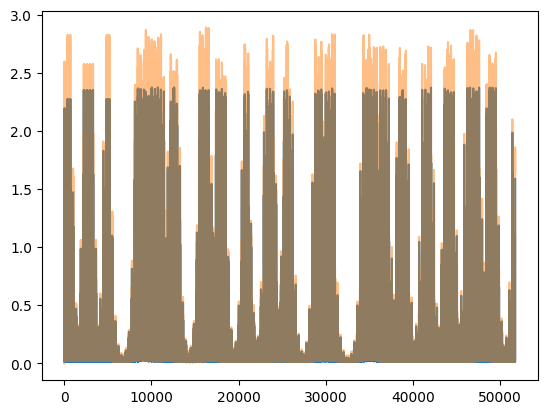

Training R2 value: 0.9321
Saving model


Epoch 11/40: Train Loss 0.4071, Learning Rate 0.0010


Epoch 12/40: Train Loss 0.4167, Learning Rate 0.0010
Training R2 value: 0.9753


Epoch 13/40: Train Loss 0.3534, Learning Rate 0.0010


Epoch 14/40: Train Loss 0.3761, Learning Rate 0.0010
Training R2 value: 0.9712


Epoch 15/40: Train Loss 0.3772, Learning Rate 0.0010
Saving model


Epoch 16/40: Train Loss 0.4038, Learning Rate 0.0010
Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.
Training R2 value: 0.9742


Epoch 17/40: Train Loss 0.3456, Learning Rate 0.0005


Epoch 18/40: Train Loss 0.3460, Learning Rate 0.0005
Training R2 value: 0.9759


Epoch 19/40: Train Loss 0.3417, Learning Rate 0.0005


Epoch 20/40: Train Loss 0.3393, Learning Rate 0.0005
Epoch [20/40], Loss: 0.3393


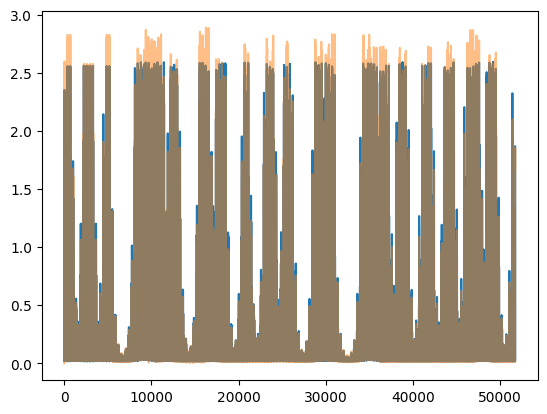

Training R2 value: 0.9751
Saving model


Epoch 21/40: Train Loss 0.3482, Learning Rate 0.0005


Epoch 22/40: Train Loss 0.3703, Learning Rate 0.0005
Epoch 00022: reducing learning rate of group 0 to 2.5000e-04.
Training R2 value: 0.9685


Epoch 23/40: Train Loss 0.3256, Learning Rate 0.0003


Epoch 24/40: Train Loss 0.3392, Learning Rate 0.0003
Training R2 value: 0.9759


Epoch 25/40: Train Loss 0.3184, Learning Rate 0.0003
Saving model


Epoch 26/40: Train Loss 0.3199, Learning Rate 0.0003
Training R2 value: 0.9761


Epoch 27/40: Train Loss 0.3221, Learning Rate 0.0003


Epoch 28/40: Train Loss 0.3206, Learning Rate 0.0003
Epoch 00028: reducing learning rate of group 0 to 1.2500e-04.
Training R2 value: 0.9755


Epoch 29/40: Train Loss 0.3151, Learning Rate 0.0001


Epoch 30/40: Train Loss 0.3131, Learning Rate 0.0001
Epoch [30/40], Loss: 0.3131


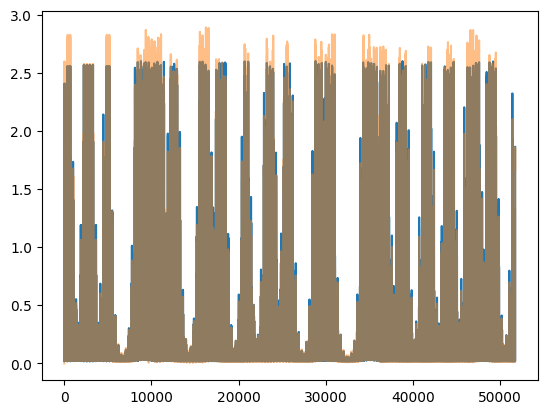

Training R2 value: 0.9755
Saving model


Epoch 31/40: Train Loss 0.3101, Learning Rate 0.0001


Epoch 32/40: Train Loss 0.3113, Learning Rate 0.0001
Training R2 value: 0.9755


Epoch 33/40: Train Loss 0.3169, Learning Rate 0.0001


Epoch 34/40: Train Loss 0.3207, Learning Rate 0.0001
Epoch 00034: reducing learning rate of group 0 to 6.2500e-05.
Training R2 value: 0.9763


Epoch 35/40: Train Loss 0.3061, Learning Rate 0.0001
Saving model


Epoch 36/40: Train Loss 0.3070, Learning Rate 0.0001
Training R2 value: 0.9757


Epoch 37/40: Train Loss 0.3088, Learning Rate 0.0001


Epoch 38/40: Train Loss 0.3070, Learning Rate 0.0001
Epoch 00038: reducing learning rate of group 0 to 3.1250e-05.
Training R2 value: 0.9764


Epoch 39/40: Train Loss 0.3056, Learning Rate 0.0000


Epoch 40/40: Train Loss 0.3041, Learning Rate 0.0000
Epoch [40/40], Loss: 0.3041


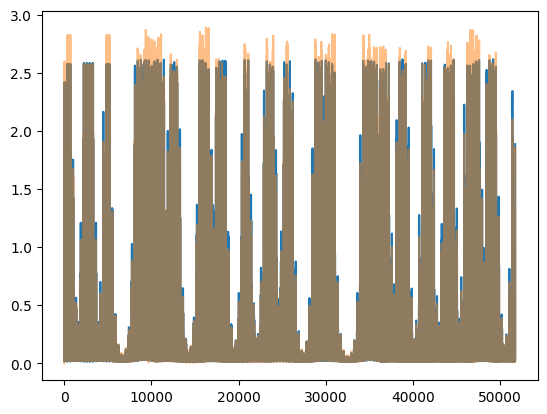

Training R2 value: 0.9762
Saving model


In [11]:
# Train the model
cum_loss_epoch=[]
for epoch in range(num_epochs):
    batch_bar = tqdm(total=len(data_loader_trn), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    model.train()
    cum_loss = 0
    # Convert inputs and labels to tensors
    
    for batch_idx, (data, target) in enumerate(data_loader_trn):
        inputs = (data.float()).to(device)
        labels = (target.float()).reshape(-1,1).to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss+=loss.item()
        batch_bar.set_postfix(
            loss="{:.04f}".format(cum_loss),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()
    batch_bar.close()
    print("Epoch {}/{}: Train Loss {:.04f}, Learning Rate {:.04f}".format(
        epoch + 1,
        num_epochs,
        float(cum_loss), 
        float(float(optimizer.param_groups[0]['lr']))
        ))

    scheduler.step(cum_loss)
    cum_loss_epoch +=[cum_loss]
    np.savetxt('sample-models/bulk-cu-torch/cum_loss.dat',cum_loss_epoch)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cum_loss:.4f}')
        plt.plot(model(soaps.to(device)).cpu().detach().numpy())
        plt.plot(rhos, alpha=0.5)
        plt.show()

    if (epoch+1)%2==0:
        model.eval()
        acc=skmetrics.r2_score(model(soaps.to(device)).cpu().detach().numpy(),rhos)
        print(f"Training R2 value: {acc:1.4f}")
        
    if (epoch+1) % 5 == 0:
        
        print('Saving model')
        torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict' : scheduler.state_dict(),
    }, f"sample-models/bulk-cu-torch/bulk-cu-"+str(epoch)+".pt")
#     print()

In [13]:
model.eval()
# Testing 0 Cu structure
test_cube_path = 'data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_0.cube'
test_cube = read_cube(open(test_cube_path))
ase_atoms_test = test_cube['atoms']
ase_atoms_test.set_pbc((True, True, True))
pos_atoms_test = ase_atoms_test.get_positions()
rho_test = test_cube['data']
rho_test = rho_test.ravel().reshape(-1,1)

start = time.time()
soap_test = copper_soap_W.create(ase_atoms_test, positions=CDP_W.box)
rho_pred = model(torch.tensor(soap_test, dtype=torch.float32).to(device)).cpu().detach().numpy()

end = time.time()
print("Prediction time: ", (end - start), " seconds.")
print(f'R2 value: {skmetrics.r2_score(rho_test,rho_pred):1.2f}')
print(f'MSE value: {skmetrics.mean_squared_error(rho_test,rho_pred):1.5f}')


Prediction time:  0.2148890495300293  seconds.
R2 value: 0.98
MSE value: 0.00249


The prediction time for this model is 0.21 seconds. This is extremely fast!

In [14]:
out=open('example/predictions/bulk-cu/pred-0-torch.cube','w+')
rho_test_resp = rho_pred.reshape(*CDP_W.bounds)
write_cube(out,ase_atoms_test,rho_test_resp,origin=CDP_W.box[0])

In [15]:
cu_cube_predict=open('example/predictions/bulk-cu/pred-0-torch.cube').read()
cu_cube_dft=open(test_cube_path).read()
CDP_W.cube2xyz(test_cube_path,'example/structures/bulk-cu/cu-0.xyz')
cu_xyz=open('example/structures/bulk-cu/cu-0.xyz').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_cube_predict,'cube',{'isoval': 0.3,"color":'red','opacity':1,'wireframe':True})
xyzview.addVolumetricData(cu_cube_dft,'cube',{'isoval': 0.3,"color":'grey','opacity':1,'wireframe':True})
# xyzview.addModel(cu_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [17]:
rho_test_resp.shape
rho_test = test_cube['data']
error = np.abs(rho_test - rho_test_resp)
out=open('example/predictions/bulk-cu/error-0-torch.cube','w+')
write_cube(out,ase_atoms_test,error,origin=CDP_W.box[0])

In [18]:
cu_error_predict=open('example/predictions/bulk-cu/error-0-torch.cube').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_error_predict,'cube',{'isoval': 0.3,"color":'blue','opacity':1,'wireframe':False})
# xyzview.addModel(water_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

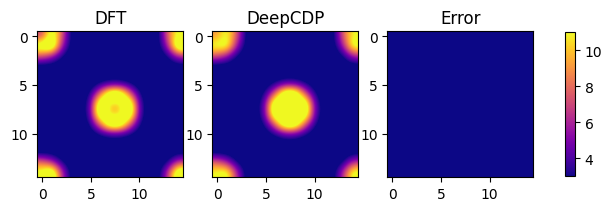

In [21]:
vmin = 3
vmax = 11
plt.subplot(131)
plt.imshow(np.trapz(rho_test, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DFT')
plt.subplot(132)
plt.imshow(np.trapz(rho_test_resp, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DeepCDP')
plt.subplot(133)
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('Error')
plt.subplots_adjust(bottom=0.0, right=0.9, top=0.9)
cax = plt.axes([0.95, 0.3, 0.015, 0.3])
plt.colorbar(cax=cax)
plt.show()
# plt.savefig('Images/Cu-soap-with-weights.png',dpi=600,bbox_inches="tight",)

Excellent prediction by the torch model that we built.

We now need to test our model on a larger bulk Cu system.

In [35]:
CDP_large = deepcdp(None)
CDP_large.create_box(sample_cubeFile='data/bulk-Cu-222/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_1.cube',gamma=90)

In [36]:
# TODO: Use the 2x2x2 results to calculate your electron densities.
model.eval()
# Testing 0 Cu structure
test_cube_path = 'data/bulk-Cu-222/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_1.cube'
test_cube = read_cube(open(test_cube_path))
ase_atoms_test = test_cube['atoms']
ase_atoms_test.set_pbc((True, True, True))
pos_atoms_test = ase_atoms_test.get_positions()
rho_test = test_cube['data']
rho_test = rho_test.ravel().reshape(-1,1)

start = time.time()
soap_test = copper_soap_W.create(ase_atoms_test, positions=CDP_large.box)
rho_pred = model(torch.tensor(soap_test, dtype=torch.float32).to(device)).cpu().detach().numpy()

end = time.time()
print("Prediction time: ", (end - start), " seconds.")
print(f'R2 value: {skmetrics.r2_score(rho_test,rho_pred):1.2f}')
print(f'MSE value: {skmetrics.mean_squared_error(rho_test,rho_pred):1.5f}')


Prediction time:  1.7682018280029297  seconds.
R2 value: 1.00
MSE value: 0.00044


We get an R^2 value of 1.0 for the larger system size. The MSE value gets even smaller than the previous case. Let's try to compare the contours and 3-D visuals of these densities. 

In [37]:
out=open('example/predictions/bulk-cu-large/pred-1-torch.cube','w+')
rho_test_resp = rho_pred.reshape(*CDP_large.bounds)
write_cube(out,ase_atoms_test,rho_test_resp,origin=CDP_large.box[0])

In [39]:
cu_cube_predict=open('example/predictions/bulk-cu-large/pred-1-torch.cube').read()
cu_cube_dft=open(test_cube_path).read()
CDP_W.cube2xyz(test_cube_path,'example/structures/bulk-cu-large/cu-1.xyz')
cu_xyz=open('example/structures/bulk-cu-large/cu-1.xyz').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_cube_predict,'cube',{'isoval': 0.3,"color":'red','opacity':1,'wireframe':True})
xyzview.addVolumetricData(cu_cube_dft,'cube',{'isoval': 0.3,"color":'grey','opacity':1,'wireframe':True})
# xyzview.addModel(cu_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [40]:
rho_test_resp.shape
rho_test = test_cube['data']
error = np.abs(rho_test - rho_test_resp)
out=open('example/predictions/bulk-cu-large/error-1-torch.cube','w+')
write_cube(out,ase_atoms_test,error,origin=CDP_large.box[0])

In [42]:
cu_error_predict=open('example/predictions/bulk-cu-large/error-1-torch.cube').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_error_predict,'cube',{'isoval': 0.3,"color":'blue','opacity':1,'wireframe':False})
# xyzview.addModel(water_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

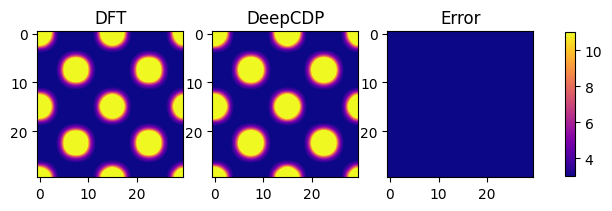

In [45]:
vmin = 3
vmax = 11
plt.subplot(131)
plt.imshow(np.trapz(rho_test, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DFT')
plt.subplot(132)
plt.imshow(np.trapz(rho_test_resp, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DeepCDP')
plt.subplot(133)
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('Error')
plt.subplots_adjust(bottom=0.0, right=0.9, top=0.9)
cax = plt.axes([0.95, 0.3, 0.015, 0.3])
plt.colorbar(cax=cax)
plt.show()
# plt.savefig('Images/Cu-soap-with-weights.png',dpi=600,bbox_inches="tight",)